In [1]:
import numpy as np
from astropy.stats import LombScargle
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

# t is a linear time without reference to angular frequencies
# signal at frequency 1
def signal(N, cycles, noise):
    """
    :param N: number of samples in output sequence y
    :param cycles: number of cycles of signal to appear in sequence
    :param noise: amplitude of noise (signal has amplitude 1)
    :returns: t, y = arrays containing time, signal sequences, with 
    signal appearing at frequency 1
    """
    t = np.linspace(0, cycles, N)
    y = np.sin(2* np.pi * t) + np.random.rand(N) * noise
    return t, y

def fft(t, x):
    """
    :param t: linear time array
    :param y: signal sequence
    :returns: f, P = arrays containing (positive) frequencies of FFT and corresponding
    power spectrum (frequency in cycles / unit time)
    """
    N = len(t)
    f = np.fft.fftfreq(N, t[1]-t[0]) # this computes frequency w.r.t Delta t
    i = (f>0)
    f = f[i]
    P = abs(np.fft.fft(x)[i]) ** 2 / N
    return f, P

Let's use a signal with both sine and noise amplitude equal to 1 and 16 cycles in 256 data points (frequency of the signal is 1, i.e. sampling frequency is 1/16).

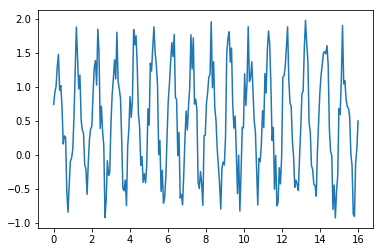

In [2]:
N = 256
C = 16
t, x = signal(N, C, 1)
plt.plot(t, x)

## Power spectrum and power spectral density

[Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem) gives the relationship between the variance ($\equiv$ RMS, energy) of a time-domain signal and its Fourier transform:
$$
\int_{-\infty}^{\infty} \left| x(t) \right|^2 df = 
\frac{1}{2 \pi} \int_{-\infty}^{\infty} \left| \tilde{X}(\omega) \right|^2 d \omega =
\int_{-\infty}^{\infty} \left| \tilde{X}(2 \pi f) \right|^2 df
$$
which in the discrete form becomes:
$$
\sum_{n=0}^{N-1} \left| x[n] \right|^2 = \frac{1}{N} \sum_{k=0}^{N-1} \left| \tilde{X}[k] \right|^2
$$

The relationship between the **power spectrum** ($PS$, given in $U^2$ where $U$ is the measurement unit) and the **power spectral density** ($PSD$, given in $U^2 T$ where $T$ is the time unit) is <cite data-cite="2031184/A4NPSUMX"></cite>:
$$
PS = PSD \times ENBW
$$
where $ENBW$ is the effective noise bandwith
$$
ENBW = f_s \frac{\sum_j w_j^2}{\left( \sum_j w_j \right)^2}
$$
where $w_j$ are the weights of any window function used and $f_s$ is the sampling frequency. For a straightforward Fourier transform without any windowing or averaging, the $w_j=1$ and hence
$$
PSD = \frac{1}{f_s} PS
$$
Note that with a total measurement period $T$, $f_s=1/\Delta t = N/T$, and therefore with $T=1$ as an un-normalized FFT assumes,
$$
PSD = \frac{1}{N} PS
$$
The relationship with the Fourier transform is:
$$
PS(f_k) = 2 \frac{\left| \tilde{X}[k] \right|^2}{\left( \sum_j w_j \right)^2} \\
PSD(f_k) = \frac{2}{f_s} \frac{\left| \tilde{X}[k] \right|^2}{\sum_j w_j^2}
$$
The factor of 2 arises because one typically only considers the positive frequencies of the Fourier transform, while for an inverse transform which reconstitutes the original signal, both negative and positive frequencies (whose modulus is symmetric about 0) will be summed. For this reason, a straightforward FFT gives back the **amplitude** of a sine component as
$$
A(f_k) = \frac{2}{N} \left| \tilde{X}[k] \right|
$$
Chosing the $C^{th}$ element in the returned fft array, where $C$ is the number of cycles of the periodic signal:

In [3]:
p = np.fft.fft(x)[C]
2 * abs(p) / N

1.0004072958571424

On the other hand, $PS$ and $PSD$ give the root mean square of the signal, which is related to the amplitude by a factor of $\sqrt{2}$ for the sinusoids of a Fourier transform:
$$
A(f_k) = \sqrt{2 PS(f_k)} 
$$
This also shows that the [*numpy.fft.fft* implementation](https://docs.scipy.org/doc/numpy-1.12.0/reference/routines.fft.html) is not normalized in the forward transform, i.e.:
$$
\tilde{X}[k] = \sum_{n=0}^{N-1} x(t_n) e^{-2 \pi i n k / N}.
$$
The *astropy.stats.LombScargle* implementation is normalized such that, with normalization='psd', it gives the same result as
$$
\frac{\left| \tilde{X}[k] \right|^2}{N}
$$
i.e. it gives $PSD$ without the $2\times$ factor.

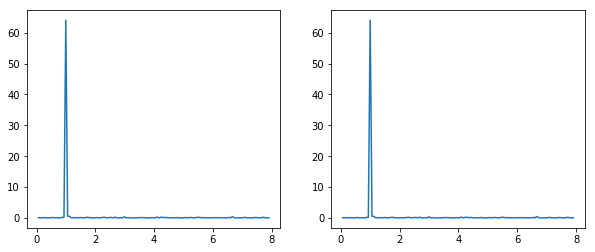

In [5]:
f, P = fft(t, x)
LS = LombScargle(t, x).power(f, normalization='psd')
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(f, P)
plt.subplot(1,2,2)
plt.plot(f, LS);

To get amplitude from *astropy.stats.LombScargle*, one would need
$$
A(f_k) = 2 \left( \frac{PSD(f_k)}{N} \right)^{1/2}
$$

In [ ]:
p = LombScargle(t, x).power(1, normalization='psd') # remember, frequency of the signal is 1
2 * np.sqrt(p/N)

On the other hand the *scipy.signal.periodogram* routine is normalized with the $2\times$ factor, and can also be given $f_s$ directly as an argument.

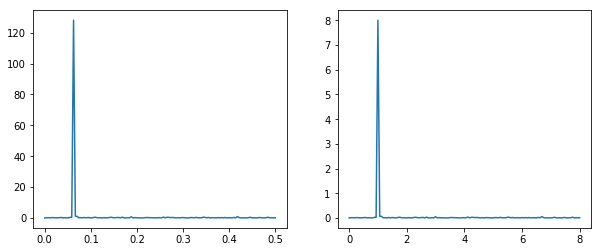

In [6]:
f, P = sig.periodogram(x)
fig = plt.figure(figsize=(10,4))
plt.plot(f, P)
plt.subplot(1,2,1)
plt.plot(f, P)
# N/C is sampling frequency
f, PG = sig.periodogram(x, N/C)
plt.subplot(1,2,2)
plt.plot(f, PG)

For amplitude, one therefore has, for *scipy.signal.periodogram*:
$$
A(f_k) = \left(2 \frac{PSD(f_k)}{N} \right)^{1/2}
$$

In [7]:
f, pg = sig.periodogram(x)
np.sqrt(2 * pg[C] / N)

1.0004072958571424

## Windowing

### "DFT-even" and symmetric windows
The *sym* option in SciPy's [window functions](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.hann.html#scipy.signal.hann) produces, when set to *False* and the window length is even a "DFT even" (or "periodic") window, i.e. one with symmetry about a central point which attains the value 1, but with the first element set to 0. This is useful for DFTs because they have an implied periodicity: the result would be unchanged if an $(N+1)^{th}$ value identical to the $0^{th}$ value followed a sequence of $N$ (an even number) elements <cite data-cite="2031184/N92WUBJI"></cite>. SciPy's implementation sets the first element of the window to zero, while Harris does it with last one - I don't know why.

### Window coherent and incoherent gain 
The application of a window function reduces the *gain* of the resulting DFT, changing the amplitude estimates. The *coherent* gain refers to the gain of the sinusoidal signal and is given by
$$
S_1 = \sum_j w_j
$$
in the nomenclature of <cite data-cite="2031184/A4NPSUMX"></cite>. The *incoherent* gain refers to the gain experienced by the white noise and is given by
$$
S_2 = \sum_j w_j^2
$$
and therefore
$$
ENBW = f_s \frac{S_2}{(S_1)^2}.
$$
If we are interested in the power or amplitude spectrum, we normalize the windowed Fourier transform by $S_1$; if we are interested in the power spectral density, by $S_2$. **The sums already contain the normalization for different window lengths.**

In [9]:
def welch(t, x, n):
    """
    Welch's method computes the average of the power spectra of windowed sub-sequences that
    overlap by 50%. The window is a Hann window.
    :param t: time sequence
    :param y: signal sequence
    :param n: number of non-overlapping subsequences (total number: 2n-1)
    """
    N = len(x)
    w = N // n # width
    win = sig.hann(w, sym=False)
    d = w // 2
    m = np.mean([LombScargle(t[:w], x[j*d:j*d+w] * win).power(1, normalization='psd')
        for j in range(2 * n - 1)])
    # we normalize by 'S_1', but we also have to multiply by w ~ f_s
    # since the computation by LombScargle already contains that factor
    return 2 * np.sqrt(w * m) / np.sum(win)

[welch(t, x, n) for n in [1,2,4,8,16]]

[1.0230808690013165,
 1.0256119524509595,
 1.0251480637440256,
 1.0236808458226192,
 1.1444195263435344]

As comparison, here the amplitude estimate from simple "period folding":

In [10]:
y = x.reshape((16,-1)).mean(0)
(max(y) - min(y)) / 2

1.0977761476195331

Welch's original paper <cite data-cite="2031184/JJJBDPIV"></cite> normalizes by $S_2$ but apparently not by $f_s$ (or $N$), which should result in a $PSD$ that depends on window size. Similarly, the *scipy.signal.welch* implementation gives window-size dependent results:

In [12]:
[sig.welch(x, nperseg=n)[1][n//C] for n in [256, 128, 64, 32]]

[88.400797040085266, 44.574068174855121, 22.32957606041645, 11.135419724082912]

This is true independent on whether the frequency is given as argument:

In [13]:
[sig.welch(x, fs=N/C, nperseg=n)[1][n//C] for n in [256, 128, 64, 32]]

[5.5250498150053291,
 2.7858792609284451,
 1.3955985037760281,
 0.69596373275518197]

For a Hann window, the default for *scipy.signal.welch*, $S_2/S_1 = 3$, and the correct result for the amplitude (remember: $PS=PSD \times ENBW$) is obtained by dividing by the window length and multiplying by 3:

In [14]:
[3 * sig.welch(x, nperseg=n)[1][n//C] / n for n in [256, 128, 64, 32]]

[1.0359468403134993, 1.044704722848167, 1.046698877832021, 1.0439455991327731]

## Coherence
Coherence of a raw DFT is always 1. Only when averaging over windows is employed can coherence be estimated. 

[The correct definition is](https://www.dsprelated.com/freebooks/mdft/Coherence_Function.html):
$$
\hat{C}_{xy}(\omega_k) = \frac{\left| \left\{ \overline{X_m(\omega_k)} Y_m(\omega_k) \right\}_m \right|^2}
{\left\{ \left| X_m(\omega_k) \right|^2 \right\}_m \left\{ \left| Y_m(\omega_k) \right|^2 \right\}_m}
$$

where the overbar denotes complex conjugation and the curly brackets averaging over windows $m$. Note the respective order of taking averages and moduli. 

In [16]:
w = sig.get_window('hann', 16)

array([ 0.        ,  0.03806023,  0.14644661,  0.30865828,  0.5       ,
        0.69134172,  0.85355339,  0.96193977,  1.        ,  0.96193977,
        0.85355339,  0.69134172,  0.5       ,  0.30865828,  0.14644661,
        0.03806023])